<a href="https://colab.research.google.com/github/google-research/google-research/blob/master/mediapipe/examples/android/src/java/com/google/mediapipe/apps/handtrackinggpu/notebooks/keypoint_training_transformer_self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keypoint Classification - Transformer Self-Attention

This notebook implements and explains an **advanced Transformer-style self-attention model** for **static hand gesture classification** using **21 Mediapipe hand landmarks** (x, y). We treat **each joint as a token** and let the model learn **relationships between joints** via **multi-head self-attention**.

We will compare between **Transformer Self-Attention** and **MLP** models.

## 1. Setup & Imports

In [12]:
!pip install -q matplotlib seaborn scikit-learn pandas xgboost

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import xgboost as xgb
import datetime

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.1


## 2. Load Dataset

We assume you have a CSV file named `keypoint_10gestures.csv` with the following format:
-   Column 0: Label (integer, 0-9)
    * 0 — Open Hand / Palm ✋
    * 1 — Closed Fist ✊
    * 2 — Pointing (Index Finger) 👉
    * 3 — OK Sign 👌
    * 4 — Peace / Victory ✌️
    * 5 — Rock / Metal (Sign of the Horns) 🤘
    * 6 — Thumbs Up 👍
    * 7 — Thumbs Down 👎
    * 8 — Pinch / Pinching Hand (C-shape) 🤏
    * 9 — Love / Finger Heart 🫰
-   Columns 1..42: x, y coordinates for 21 hand landmarks.

If you don't have it, please upload it or adjust the path below.


In [56]:
# Path to your dataset
dataset_path = '../data/keypoint_10gestures.csv'
model_save_path = '../model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = '../model/keypoint_classifier/keypoint_classifier.tflite'

# Number of classes (adjust based on your dataset)
NUM_CLASSES = 10

# Load data
try:
    df = pd.read_csv(dataset_path, header=None)
    print(f"Dataset loaded. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {dataset_path}. Please upload or fix the path.")
    # Create dummy data for demonstration if file is missing
    print("Creating dummy data for demonstration...")
    df = pd.DataFrame(np.random.rand(1000, 43))
    df[0] = np.random.randint(0, NUM_CLASSES, 1000)


Dataset loaded. Shape: (28677, 43)


## 3. Preprocessing

We split the data into features (X) and labels (y), and then into training and testing sets.


In [14]:
X_dataset = df.iloc[:, 1:].values
y_dataset = df.iloc[:, 0].values

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, y_dataset,
    test_size=0.25,
    random_state=SEED
)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")


X_train: (21507, 42), y_train: (21507,)
X_test:  (7170, 42),  y_test:  (7170,)


## 4. Utility Functions

Helper functions for evaluation and plotting.


In [15]:
def plot_confusion_matrix(cm, class_labels, title="Confusion matrix"):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    tick_marks = np.arange(len(class_labels))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_labels)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_labels)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    
    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

def evaluate_classifier_predictions(y_true_train, y_pred_train, y_true_test, y_pred_test, model_name="model"):
    train_acc = accuracy_score(y_true_train, y_pred_train)
    test_acc  = accuracy_score(y_true_test,  y_pred_test)
    train_f1  = f1_score(y_true_train, y_pred_train, average="macro")
    test_f1   = f1_score(y_true_test,  y_pred_test,  average="macro")

    print(f"=== {model_name} ===")
    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Test  accuracy: {test_acc:.4f}")
    print(f"Train macro-F1: {train_f1:.4f}")
    print(f"Test  macro-F1: {test_f1:.4f}")

    print("\nClassification report (test set):")
    print(classification_report(y_true_test, y_pred_test, digits=4))

    cm = confusion_matrix(y_true_test, y_pred_test)
    return {
        "model": model_name,
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "train_macro_f1": train_f1,
        "test_macro_f1": test_f1,
        "confusion_matrix": cm
    }


## 5. Baseline: MLP

We train a simple Multi-Layer Perceptron as a baseline.

### What is an MLP?
A **Multi-Layer Perceptron (MLP)** is a fundamental type of neural network. It consists of layers of nodes (neurons) connected by weights. 

### Why use it?
- **Simplicity:** It's easy to implement and understand.
- **Speed:** It trains and predicts very quickly, making it suitable for real-time applications on low-power devices.
- **Baseline:** It serves as a great starting point to compare more complex models against.

### How does it work?
1.  **Input Layer:** Takes the 42 coordinates (x, y for 21 points) as a flat list of numbers.
2.  **Hidden Layers:** These layers transform the input features using weighted connections and activation functions (like ReLU). They learn to detect patterns in the coordinates.
3.  **Output Layer:** Produces a probability score for each gesture class. The class with the highest score is the prediction.


In [ ]:
mlp_baseline = keras.Sequential(
    [
        layers.Input(shape=(INPUT_DIM,), name="input_features"),

        # Hidden layer 1
        layers.Dense(64, activation="relu", name="dense_1_64"),
        layers.Dropout(0.2, name="dropout_1"),

        # Hidden layer 2
        layers.Dense(32, activation="relu", name="dense_2_32"),
        layers.Dropout(0.2, name="dropout_2"),

        # Output layer
        layers.Dense(NUM_CLASSES, activation="softmax", name="output"),
    ],
    name="mlp_classifier",
)

mlp_baseline.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

es_mlp = keras.callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True,
    verbose=1,
)

hist_mlp = mlp_baseline.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=128,
    callbacks=[es_mlp],
    verbose=1,
)

Epoch 1/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3339 - loss: 1.9166 - val_accuracy: 0.6053 - val_loss: 1.3900
Epoch 2/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5715 - loss: 1.2569 - val_accuracy: 0.7597 - val_loss: 0.9015
Epoch 3/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6860 - loss: 0.9413 - val_accuracy: 0.8393 - val_loss: 0.6828
Epoch 4/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7412 - loss: 0.7885 - val_accuracy: 0.8646 - val_loss: 0.5696
Epoch 5/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7783 - loss: 0.6874 - val_accuracy: 0.8795 - val_loss: 0.4846
Epoch 6/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8025 - loss: 0.6120 - val_accuracy: 0.8901 - val_loss: 0.4353
Epoch 7/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8201 - loss: 0.5643 - val_accuracy: 0.9052 - val_loss: 0.3882
Epoch 8/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8348 - loss: 0.5182 - val_accu

### 5.1 MLP Evaluation

673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
=== MLP_baseline ===
Train accuracy: 0.9881
Test  accuracy: 0.9837
Train macro-F1: 0.9881
Test  macro-F1: 0.9837

Classification report (test set):
              precision    recall  f1-score   support

           0     0.9727    0.9903    0.9814       719
           1     0.9791    0.9944    0.9867       708
           2     0.9777    0.9615    0.9695       728
           3     0.9889    0.9739    0.9813       729
           4     0.9830    0.9598    0.9713       722
           5     0.9831    0.9873    0.9852       707
           6     0.9986    0.9972    0.9979       726
           7     0.9971    0.9941    0.9956       683
           8     0.9689    0.9876    0.9782       726
           9     0.9890    0.9917    0.9903       722

    accuracy                         0.9837      7170
   macro avg     0.9838    0.9838    0.9837      7170
weighted avg     0.9837    0.9837    0.9837      7170



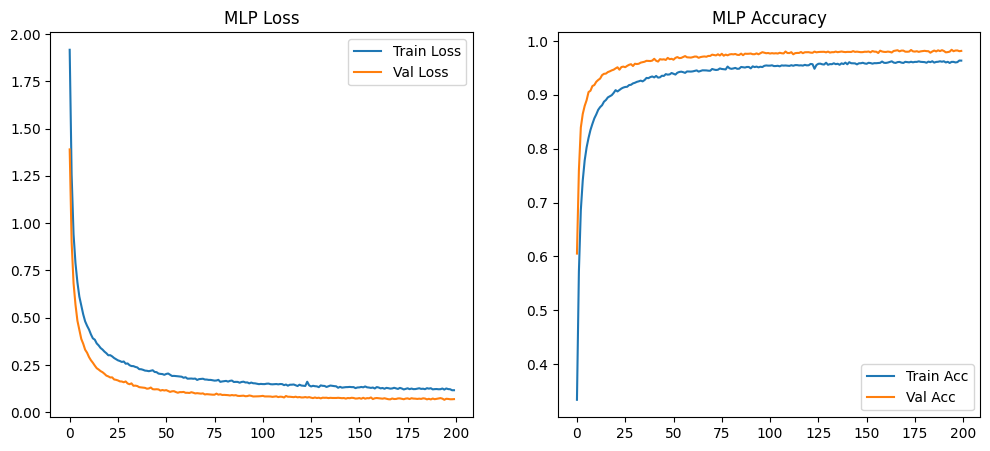

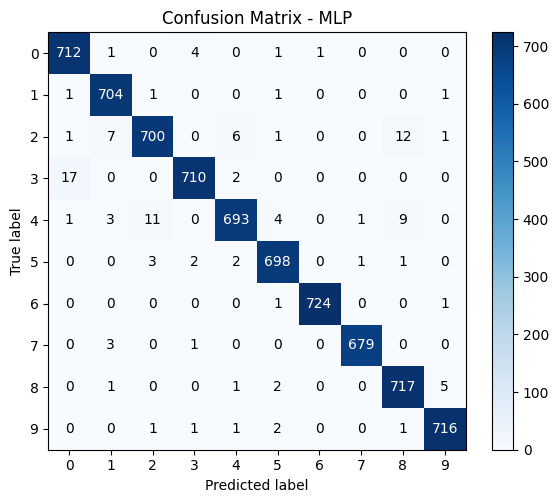

In [17]:
# 1. Accuracy & Classification Report
y_pred_mlp_train = np.argmax(mlp_baseline.predict(X_train), axis=1)
y_pred_mlp_test  = np.argmax(mlp_baseline.predict(X_test), axis=1)

mlp_metrics = evaluate_classifier_predictions(
    y_train, y_pred_mlp_train,
    y_test,  y_pred_mlp_test,
    model_name="MLP_baseline"
)

# 2. Learning Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_mlp.history['loss'], label='Train Loss')
plt.plot(hist_mlp.history['val_loss'], label='Val Loss')
plt.title('MLP Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_mlp.history['accuracy'], label='Train Acc')
plt.plot(hist_mlp.history['val_accuracy'], label='Val Acc')
plt.title('MLP Accuracy')
plt.legend()
plt.show()

# 3. Confusion Matrix
plot_confusion_matrix(
    mlp_metrics["confusion_matrix"],
    class_labels=np.unique(y_dataset),
    title="Confusion Matrix - MLP"
)


## 6. Baseline: XGBoost

We train a Gradient Boosting Decision Tree model using XGBoost.

### What is XGBoost?
**XGBoost (Extreme Gradient Boosting)** is a powerful machine learning algorithm that uses an ensemble of decision trees.

### Why use it?
- **Performance:** It often perform better on tabular data (like our list of coordinates).
- **Robustness:** It handles missing values well and is generally less prone to overfitting than a single decision tree.
- **Efficiency:** It's optimized for speed and performance.

### How does it work?
1.  **Ensemble Learning:** Instead of relying on one model, it combines the predictions of many simple models (decision trees).
2.  **Boosting:** It builds trees sequentially. Each new tree tries to correct the errors made by the previous trees. It focuses more on the "hard" examples that were misclassified.
3.  **Final Prediction:** The final output is a weighted sum of the predictions from all the trees.


In [18]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train)


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:25:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


### 6.1 XGBoost Evaluation

=== XGB_baseline ===
Train accuracy: 0.9996
Test  accuracy: 0.9842
Train macro-F1: 0.9996
Test  macro-F1: 0.9843

Classification report (test set):
              precision    recall  f1-score   support

           0     0.9780    0.9889    0.9834       719
           1     0.9709    0.9887    0.9797       708
           2     0.9750    0.9643    0.9696       728
           3     0.9958    0.9794    0.9876       729
           4     0.9831    0.9668    0.9749       722
           5     0.9901    0.9915    0.9908       707
           6     0.9959    0.9959    0.9959       726
           7     0.9956    0.9927    0.9941       683
           8     0.9729    0.9904    0.9816       726
           9     0.9861    0.9848    0.9854       722

    accuracy                         0.9842      7170
   macro avg     0.9843    0.9843    0.9843      7170
weighted avg     0.9843    0.9842    0.9842      7170



<Figure size 1000x600 with 0 Axes>

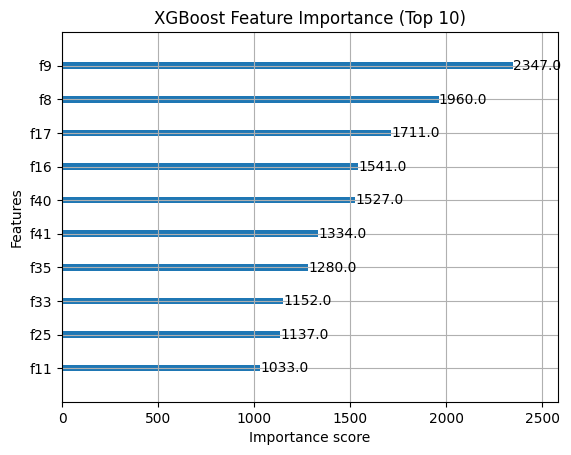

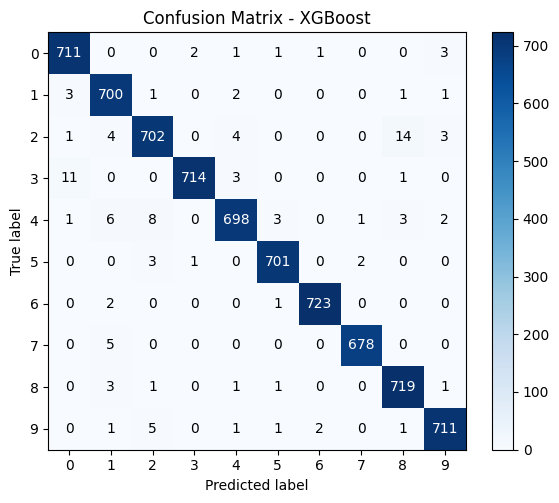

In [19]:
# 1. Accuracy & Classification Report
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test  = xgb_model.predict(X_test)

xgb_metrics = evaluate_classifier_predictions(
    y_train, y_pred_xgb_train,
    y_test,  y_pred_xgb_test,
    model_name="XGB_baseline"
)

# 2. Learning Curves (Not applicable for standard XGBoost fit without eval_set, skipping)
# Alternatively, we could plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("XGBoost Feature Importance (Top 10)")
plt.show()

# 3. Confusion Matrix
plot_confusion_matrix(
    xgb_metrics["confusion_matrix"],
    class_labels=np.unique(y_dataset),
    title="Confusion Matrix - XGBoost"
)


## 7. Transformer (Self-Attention)

We treat the 21 landmarks as a sequence of tokens (or just a set of features) and apply self-attention.

### What is a Transformer?
A **Transformer** is a deep learning architecture originally designed for language tasks (like translation) but now widely used in computer vision. It relies on a mechanism called "Self-Attention."

### Why use it?
- **Context Awareness:** It excels at understanding relationships between different parts of the input, regardless of how far apart they are.
- **Spatial Structure:** For hand gestures, it can learn how the position of one finger relates to another (e.g., thumb touching index finger) to form a specific shape.

### How does it work?
1.  **Input as Sequence:** We treat the 21 hand keypoints as a sequence of 21 items (tokens).
2.  **Self-Attention:** This mechanism allows the model to look at each keypoint and decide how much "attention" to pay to every other keypoint. For example, when analyzing the thumb tip, the model might pay close attention to the index finger tip to check for a pinch gesture.
3.  **Global Understanding:** By aggregating this attention information across multiple layers, the model builds a comprehensive understanding of the hand's pose to make a prediction.


In [ ]:
def build_transformer_classifier(
    num_joints=21,
    joint_dim=2,
    d_model=64,
    num_heads=4,
    ff_multiplier=2,
    num_layers=2,
    dropout_rate=0.1,
    num_classes=10,
    use_cls_token=False
):
    # Input: (batch_size, num_joints * joint_dim)
    inputs = keras.Input(shape=(num_joints * joint_dim,))
    
    # Reshape to (batch_size, num_joints, joint_dim)
    x = layers.Reshape((num_joints, joint_dim))(inputs)
    
    # Project to d_model
    x = layers.Dense(d_model)(x)
    
    # Positional encoding (learnable)
    # We add a learnable embedding for each joint index
    if use_cls_token:
        # Add CLS token if desired (not strictly necessary for simple classification)
        cls_token = tf.Variable(tf.zeros((1, 1, d_model)), trainable=True)
        # Tile for batch size - tricky in Keras functional API without custom layer, 
        # but we can skip CLS for simplicity or use GlobalAveragePooling.
        pass

    # Transformer Encoder Blocks
    for _ in range(num_layers):
        # Self-Attention
        x1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = layers.Add()([x, x1])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Feed Forward
        x2 = layers.Dense(d_model * ff_multiplier, activation="relu")(x)
        x2 = layers.Dense(d_model)(x2)
        x2 = layers.Dropout(dropout_rate)(x2)
        x = layers.Add()([x, x2])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Classification Head
    # Global Average Pooling over the joint dimension
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="transformer_classifier")

NUM_LANDMARKS = 21
FEATURES_PER_LANDMARK = 2 # x, y

transformer = build_transformer_classifier(
    num_joints=NUM_LANDMARKS,
    joint_dim=FEATURES_PER_LANDMARK,
    d_model=64,
    num_heads=4,
    ff_multiplier=2,
    num_layers=2,
    dropout_rate=0.1,
    num_classes=NUM_CLASSES
)

transformer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

transformer.summary()

es_attn = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)

hist_attn = transformer.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=170,
    batch_size=128,
    callbacks=[es_attn],
    verbose=1
)


Model: "transformer_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 21, 2)     │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 21, 64)    │        192 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 21, 64)    │     66,368 │ dense_38[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 21, 64)    │          0 │ dense_38[0][0],   │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 21, 64)    │        128 │ add_22[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 21, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 21, 64)    │      8,256 │ dense_39[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 21, 64)    │          0 │ dense_40[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 21, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 21, 64)    │        128 │ add_23[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 21, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 21, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 21, 64)    │        128 │ add_24[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 21, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 21, 64)    │      8,256 │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 21, 64)    │          0 │ dense_42[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 21, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 21, 64)    │        128 │ add_25[0][0]    

 Total params: 167,242 (653.29 KB)

 Trainable params: 167,242 (653.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.2772 - loss: 1.9786 - val_accuracy: 0.3675 - val_loss: 1.7104
Epoch 2/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4565 - loss: 1.5013 - val_accuracy: 0.4603 - val_loss: 1.5092
Epoch 3/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5444 - loss: 1.2684 - val_accuracy: 0.6074 - val_loss: 1.1084
Epoch 4/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6290 - loss: 1.0618 - val_accuracy: 0.6774 - val_loss: 0.9164
Epoch 5/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6901 - loss: 0.8987 - val_accuracy: 0.7417 - val_loss: 0.7536
Epoch 6/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7370 - loss: 0.7765 - val_accuracy: 0.7812 - val_loss: 0.6461
Epoch 7/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7705 - loss: 0.6788 - val_accuracy: 0.8155 - val_loss: 0.5553
Epoch 8/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7942 - loss: 0.6062 -

### 7.1 Transformer Evaluation

=== Transformer(Self-Attention) ===
Train accuracy: 0.9900
Test  accuracy: 0.9757
Train macro-F1: 0.9899
Test  macro-F1: 0.9758

Classification report (test set):
              precision    recall  f1-score   support

           0     0.9671    0.9819    0.9745       719
           1     0.9667    0.9831    0.9748       708
           2     0.9669    0.9615    0.9642       728
           3     0.9780    0.9739    0.9759       729
           4     0.9728    0.9418    0.9571       722
           5     0.9630    0.9576    0.9603       707
           6     0.9918    0.9986    0.9952       726
           7     0.9985    0.9927    0.9956       683
           8     0.9715    0.9848    0.9781       726
           9     0.9820    0.9820    0.9820       722

    accuracy                         0.9757      7170
   macro avg     0.9758    0.9758    0.9758      7170
weighted avg     0.9757    0.9757    0.9757      7170



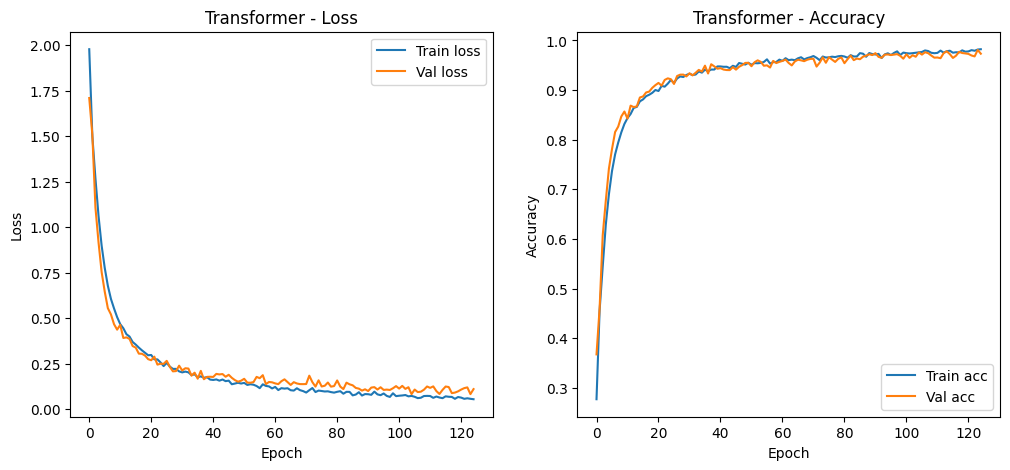

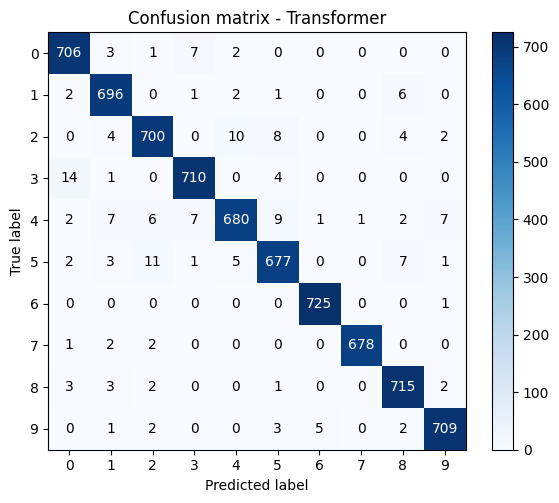

In [ ]:
# 1. Accuracy & Classification Report
y_pred_attn_train = np.argmax(transformer.predict(X_train, verbose=1), axis=1)
y_pred_attn_test  = np.argmax(transformer.predict(X_test,  verbose=1), axis=1)

attn_metrics = evaluate_classifier_predictions(
    y_train, y_pred_attn_train,
    y_test,  y_pred_attn_test,
    model_name="Transformer(Self-Attention)"
)

# 2. Learning Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_attn.history["loss"], label="Train loss")
plt.plot(hist_attn.history["val_loss"], label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Transformer - Loss"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_attn.history["accuracy"], label="Train acc")
plt.plot(hist_attn.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Transformer - Accuracy"); plt.legend()
plt.show()

# 3. Confusion Matrix
plot_confusion_matrix(
    attn_metrics["confusion_matrix"],
    class_labels=np.unique(y_dataset),
    title="Confusion matrix - Transformer"
)


## 8. Hyperparameter Tweaks (Ablation)

We try a few small variants to observe trends. **Note:** To keep runtime reasonable, we train for fewer epochs with early stopping.


In [25]:
def train_eval_variant(d_model=64, heads=4, layers_n=2, dropout=0.1, epochs=60):
    tmp = build_transformer_classifier(
        num_joints=NUM_LANDMARKS,
        joint_dim=FEATURES_PER_LANDMARK,
        d_model=d_model,
        num_heads=heads,
        ff_multiplier=2,
        num_layers=layers_n,
        dropout_rate=dropout,
        num_classes=NUM_CLASSES,
        use_cls_token=False
    )
    tmp.compile(optimizer=keras.optimizers.Adam(3e-4),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
    es = keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True, verbose=1)
    tmp.fit(X_train, y_train, validation_data=(X_test, y_test),
            epochs=epochs, batch_size=128, callbacks=[es], verbose=1)
    ypr_tr = np.argmax(tmp.predict(X_train, verbose=1), axis=1)
    ypr_te = np.argmax(tmp.predict(X_test,  verbose=1), axis=1)
    metrics = evaluate_classifier_predictions(y_train, ypr_tr, y_test, ypr_te,
                                              model_name=f"TX(d={d_model},h={heads},L={layers_n})")
    return {
        "name": f"d{d_model}_h{heads}_L{layers_n}",
        "test_acc": metrics["test_accuracy"],
        "test_macro_f1": metrics["test_macro_f1"]
    }

variants = [
    (64, 4, 2),
    (96, 4, 2),
    (64, 8, 2),
    (64, 4, 3),
]

variant_records = []
for d, h, L in variants:
    print("-"*60)
    record = train_eval_variant(d_model=d, heads=h, layers_n=L, epochs=60)
    variant_records.append(record)

ablation_df = pd.DataFrame(variant_records).sort_values("test_acc", ascending=False)
display(ablation_df)


------------------------------------------------------------
Epoch 1/60
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.2393 - loss: 2.0961 - val_accuracy: 0.3618 - val_loss: 1.8102
Epoch 2/60
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.3790 - loss: 1.7063 - val_accuracy: 0.4536 - val_loss: 1.5578
Epoch 3/60
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4617 - loss: 1.4934 - val_accuracy: 0.5066 - val_loss: 1.3808
Epoch 4/60
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5219 - loss: 1.3439 - val_accuracy: 0.5656 - val_loss: 1.2367
Epoch 5/60
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5661 - loss: 1.2356 - val_accuracy: 0.5915 - val_loss: 1.1858
Epoch 6/60
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5961 - loss: 1.1526 - val_accuracy: 0.6234 - val_loss: 1.0782
Epoch 7/60
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6260 - loss: 1.0734 - val_accuracy: 0.6550 - val_loss: 0.9954
Epoch 8/60
169/169 ━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

## 9. Evaluation & Comparison

We summarise **test set metrics** across models trained in this notebook and present a bar chart for quick comparison.


In [58]:
# 9.0 Helper: collect predictions & probabilities for all models on the test set

# Make sure the following objects already exist from previous sections:
# - X_test, y_test
# - mlp_baseline
# - xgb_model
# - transformer
# - NUM_CLASSES

MODEL_ORDER = ["MLP_baseline", "XGB_baseline", "Transformer(Self-Attention)"]

# 1) Probabilities & hard predictions
proba_mlp  = mlp_baseline.predict(X_test, verbose=0)
y_pred_mlp = np.argmax(proba_mlp, axis=1)

proba_xgb  = xgb_model.predict_proba(X_test)
y_pred_xgb = np.argmax(proba_xgb, axis=1)

proba_attn  = transformer.predict(X_test, verbose=0)
y_pred_attn = np.argmax(proba_attn, axis=1)

y_true = y_test

model_outputs = {
    "MLP_baseline": {
        "y_pred": y_pred_mlp,
        "proba":  proba_mlp,
    },
    "XGB_baseline": {
        "y_pred": y_pred_xgb,
        "proba":  proba_xgb,
    },
    "Transformer(Self-Attention)": {
        "y_pred": y_pred_attn,
        "proba":  proba_attn,
    },
}

# 2) Callables that run inference for arbitrary inputs (used for noise & latency)
model_callables = {
    "MLP_baseline": lambda X: np.argmax(mlp_baseline.predict(X, verbose=0), axis=1),
    "XGB_baseline": lambda X: xgb_model.predict(X),
    "Transformer(Self-Attention)": lambda X: np.argmax(transformer.predict(X, verbose=0), axis=1),
}


### 9.1 Overall Accuracy & Macro F1

We start with the simplest aggregate metrics on the **test set**:

- **Accuracy** (top-1)
- **Macro F1-score** (unweighted mean F1 across classes)

This gives a quick high-level view of which model performs best overall.


,model,test_accuracy,test_macro_f1
1,XGB_baseline,0.984240,0.984297
0,MLP_baseline,0.983682,0.983742
2,Transformer(Self-Attention),0.975732,0.975764


<Figure size 800x400 with 0 Axes>

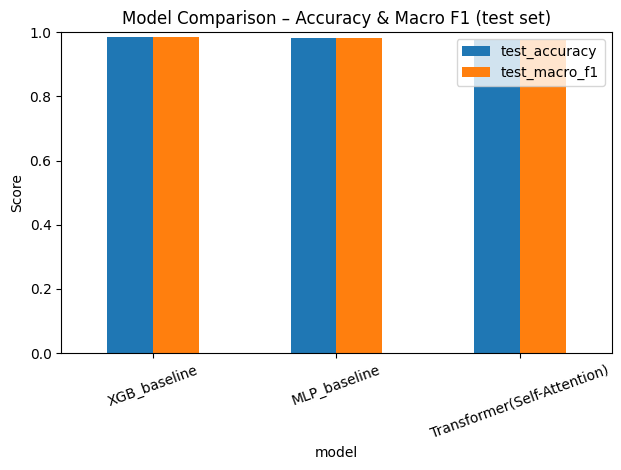

In [35]:
from sklearn.metrics import accuracy_score, f1_score

rows = []
for model_name in MODEL_ORDER:
    y_pred = model_outputs[model_name]["y_pred"]
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    rows.append({
        "model": model_name,
        "test_accuracy": acc,
        "test_macro_f1": macro_f1,
    })

summary_df = pd.DataFrame(rows).sort_values("test_accuracy", ascending=False)
display(summary_df)

# Bar plot for accuracy & macro-F1
plt.figure(figsize=(8, 4))
summary_df_plot = summary_df.set_index("model")[["test_accuracy", "test_macro_f1"]]
summary_df_plot.plot(kind="bar")
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Model Comparison – Accuracy & Macro F1 (test set)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


### 9.2 Per-class Precision / Recall / F1

Next, we drill down into **per-class behaviour**:

- **Precision**: how often a predicted class is correct.
- **Recall**: how often true instances of a class are recovered.
- **F1-score**: harmonic mean of precision & recall.

We visualise per-class precision / recall / F1 as heatmaps (classes vs. models).


,model,class,precision,recall,f1
0,MLP_baseline,0,0.972678,0.990264,0.981392
1,MLP_baseline,1,0.979138,0.994350,0.986685
2,MLP_baseline,2,0.977654,0.961538,0.969529
3,MLP_baseline,3,0.988858,0.973937,0.981341
4,MLP_baseline,4,0.982979,0.959834,0.971268


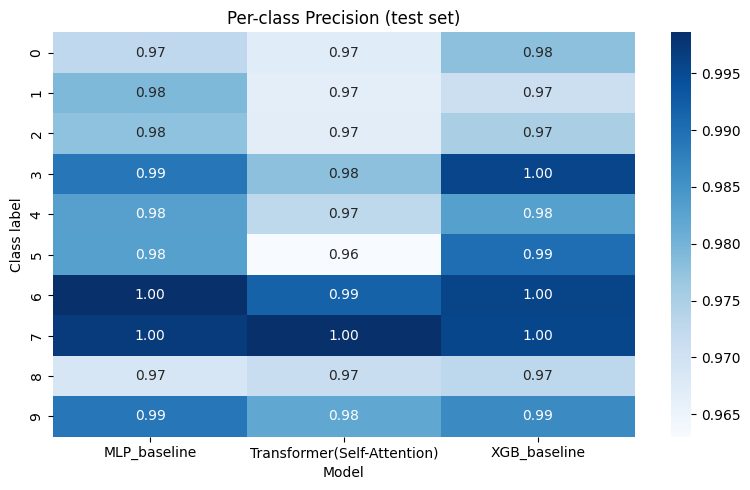

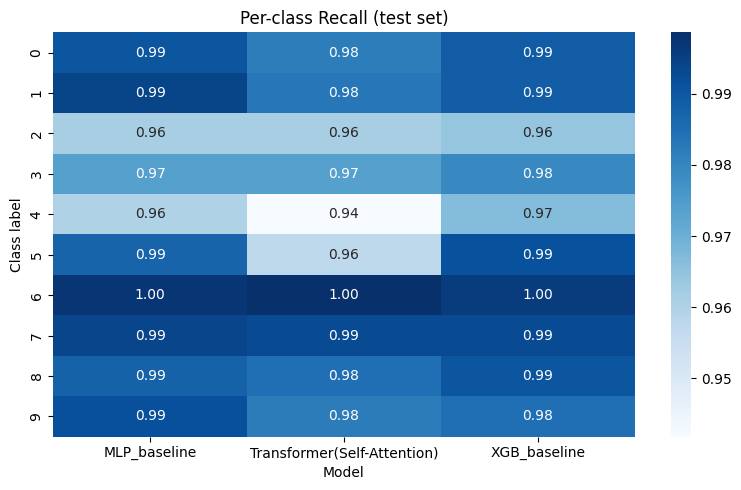

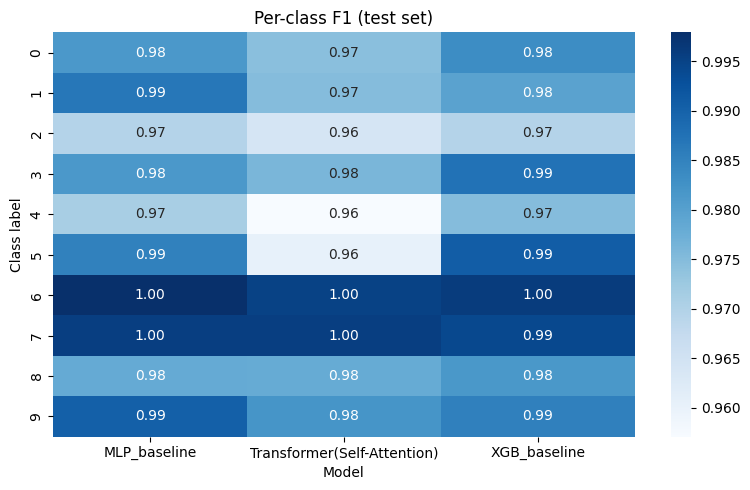

In [36]:
from sklearn.metrics import classification_report

per_class_rows = []

for model_name in MODEL_ORDER:
    y_pred = model_outputs[model_name]["y_pred"]
    # output_dict=True gives a dict with per-class metrics plus "macro avg", etc.
    report = classification_report(
        y_true, y_pred, output_dict=True, zero_division=0
    )
    
    # Per-class rows are indexed by stringified class labels: '0', '1', ...
    for class_id in range(NUM_CLASSES):
        cls_key = str(class_id)
        if cls_key in report:
            metrics = report[cls_key]
            per_class_rows.append({
                "model": model_name,
                "class": class_id,
                "precision": metrics["precision"],
                "recall": metrics["recall"],
                "f1": metrics["f1-score"],
            })

per_class_df = pd.DataFrame(per_class_rows)
display(per_class_df.head())

# Plot heatmaps for precision, recall, F1
metrics_to_plot = ["precision", "recall", "f1"]

for metric in metrics_to_plot:
    pivot_df = per_class_df.pivot(index="class", columns="model", values=metric)
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="Blues")
    plt.title(f"Per-class {metric.capitalize()} (test set)")
    plt.ylabel("Class label")
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()


### 9.3 Confusion Matrix Comparison (Relative Confusion Across Models)

Instead of plotting separate confusion matrices per model, we:

1. **Rank the most frequent confusions** for each model  
   (pairs of `(true class → predicted class)` with the highest error rate).

2. Plot **difference heatmaps** vs. the Transformer:
   - Positive values (red) → this model confuses that pair **more** than the Transformer.
   - Negative values (blue) → this model confuses that pair **less** than the Transformer.

This makes it easier to see where each model is relatively stronger or weaker in terms of misclassification patterns.


In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assumes:
# - MODEL_ORDER, NUM_CLASSES, y_true, model_outputs exist from previous cells.

# Use integer labels by default; replace with CLASS_NAMES if you have it
class_labels = np.arange(NUM_CLASSES)
label_names = globals().get("CLASS_NAMES", class_labels)

# 1) Compute confusion matrices and row-normalised confusion (per-class rates)
cms = {}
cms_norm = {}

for model_name in MODEL_ORDER:
    y_pred = model_outputs[model_name]["y_pred"]
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    cms[model_name] = cm
    
    row_sums = cm.sum(axis=1, keepdims=True)
    row_sums_safe = np.maximum(row_sums, 1)  # avoid division by zero
    cms_norm[model_name] = cm / row_sums_safe

# 2) Build a long-form DataFrame of off-diagonal confusions for each model
rows = []
for model_name in MODEL_ORDER:
    cm = cms[model_name]
    cmn = cms_norm[model_name]
    for i, true_label in enumerate(class_labels):
        for j, pred_label in enumerate(class_labels):
            if i == j:
                continue  # skip correct predictions (diagonal)
            count = cm[i, j]
            if count == 0:
                continue  # keep only actual confusions
            rate = cmn[i, j]
            rows.append({
                "model": model_name,
                "true": true_label,
                "pred": pred_label,
                "true_name": label_names[i],
                "pred_name": label_names[j],
                "count": int(count),
                "rate": rate,
            })

cm_long = pd.DataFrame(rows)

# 3) Show top-K confusions per model (by rate, then count)
TOP_K_CONFUSIONS = 10

top_confusions = (
    cm_long
    .sort_values(["model", "rate", "count"], ascending=[True, False, False])
    .groupby("model")
    .head(TOP_K_CONFUSIONS)
    .reset_index(drop=True)
)

print(f"Top {TOP_K_CONFUSIONS} confusion pairs per model (true → predicted):")
display(top_confusions[[
    "model", "true_name", "pred_name", "rate", "count"
]])

# 4) Difference heatmaps vs. Transformer (where do others confuse more/less?)
reference_model = "Transformer(Self-Attention)"
ref_norm = cms_norm[reference_model]

for model_name in MODEL_ORDER:
    if model_name == reference_model:
        continue
    
    diff = cms_norm[model_name] - ref_norm
    # Zero out the diagonal so we focus purely on misclassifications
    diff = diff.copy()
    np.fill_diagonal(diff, 0.0)
    
    plt.figure(figsize=(7, 5))
    sns.heatmap(
        diff,
        xticklabels=label_names,
        yticklabels=label_names,
        cmap="coolwarm",
        center=0.0,
        fmt=".2f",
        annot=False
    )
    plt.title(f"Confusion difference: {model_name} minus {reference_model}\n"
              "(positive = more confusion than Transformer)")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.tight_layout()
    plt.show()


TypeError: 'NoneType' object is not subscriptable

#### 9.3.1 Similar Gesture Comparison: Hand Pinch (8) vs Hand Love (9)

We now zoom in on two **visually similar gestures**:

- **Label 8**: hand pinch  
- **Label 9**: hand love  

We compare how each model:

1. Confuses **8 ↔ 9** (local confusion rates).
2. Separates them in a **binary subtask** “is this 8 or 9?”.


In [45]:
from sklearn.metrics import confusion_matrix, classification_report

SIMILAR_PAIR = (8, 9)
label_a, label_b = SIMILAR_PAIR

# Optional: human-readable names if you have them
CLASS_NAMES = globals().get("CLASS_NAMES", None)
label_a_name = CLASS_NAMES[label_a] if CLASS_NAMES is not None else f"class {label_a}"
label_b_name = CLASS_NAMES[label_b] if CLASS_NAMES is not None else f"class {label_b}"

summary_rows = []

for model_name in MODEL_ORDER:
    y_pred = model_outputs[model_name]["y_pred"]
    
    # Full confusion matrix
    cm_full = confusion_matrix(y_true, y_pred, labels=np.arange(NUM_CLASSES))
    
    # Row sums for true labels A and B
    row_a_sum = cm_full[label_a, :].sum()
    row_b_sum = cm_full[label_b, :].sum()
    
    # Avoid zero-division if a class never appears
    row_a_sum = max(row_a_sum, 1)
    row_b_sum = max(row_b_sum, 1)
    
    # Local confusion rates for these two classes
    correct_a = cm_full[label_a, label_a] / row_a_sum
    correct_b = cm_full[label_b, label_b] / row_b_sum
    
    a_as_b = cm_full[label_a, label_b] / row_a_sum
    b_as_a = cm_full[label_b, label_a] / row_b_sum
    
    a_as_other = (row_a_sum - cm_full[label_a, label_a] - cm_full[label_a, label_b]) / row_a_sum
    b_as_other = (row_b_sum - cm_full[label_b, label_b] - cm_full[label_b, label_a]) / row_b_sum
    
    summary_rows.append({
        "model": model_name,
        f"P(pred={label_a} | true={label_a})": correct_a,
        f"P(pred={label_b} | true={label_a})": a_as_b,
        f"P(other | true={label_a})": a_as_other,
        f"P(pred={label_b} | true={label_b})": correct_b,
        f"P(pred={label_a} | true={label_b})": b_as_a,
        f"P(other | true={label_b})": b_as_other,
    })

pair_confusion_df = pd.DataFrame(summary_rows)
print(f"Local confusion rates for similar gestures {label_a} ({label_a_name}) "
      f"and {label_b} ({label_b_name}):")
display(pair_confusion_df)


Local confusion rates for similar gestures 8 (class 8) and 9 (class 9):


,model,P(pred=8 | true=8),P(pred=9 | true=8),P(other | true=8),P(pred=9 | true=9),P(pred=8 | true=9),P(other | true=9)
0,MLP_baseline,0.987603,0.006887,0.005510,0.991690,0.001385,0.006925
1,XGB_baseline,0.990358,0.001377,0.008264,0.984765,0.001385,0.013850
2,Transformer(Self-Attention),0.984848,0.002755,0.012397,0.981994,0.002770,0.015235


In [46]:
binary_rows = []

for model_name in MODEL_ORDER:
    y_pred = model_outputs[model_name]["y_pred"]
    
    # Restrict to samples where the true label is either 8 or 9
    mask_pair = np.isin(y_true, SIMILAR_PAIR)
    y_true_pair = y_true[mask_pair]
    y_pred_pair = y_pred[mask_pair]
    
    # Map labels {8, 9} → {0, 1}
    mapping = {label_a: 0, label_b: 1}
    y_true_bin = np.vectorize(mapping.get)(y_true_pair)
    
    # Only keep predictions of 8 or 9 (others go to "other" class)
    # For the pure binary view, we force any non-8/9 prediction to "wrong class"
    y_pred_bin = np.where(y_pred_pair == label_a, 0,
                          np.where(y_pred_pair == label_b, 1, 1 - y_true_bin))
    
    cm_bin = confusion_matrix(y_true_bin, y_pred_bin, labels=[0, 1])
    report_bin = classification_report(
        y_true_bin,
        y_pred_bin,
        target_names=[f"{label_a} ({label_a_name})",
                      f"{label_b} ({label_b_name})"],
        output_dict=True,
        zero_division=0,
    )
    
    binary_rows.append({
        "model": model_name,
        "num_samples_pair": len(y_true_pair),
        "binary_accuracy_8_vs_9": report_bin["accuracy"],
        f"precision_{label_a}": report_bin[f"{label_a} ({label_a_name})"]["precision"],
        f"recall_{label_a}": report_bin[f"{label_a} ({label_a_name})"]["recall"],
        f"f1_{label_a}": report_bin[f"{label_a} ({label_a_name})"]["f1-score"],
        f"precision_{label_b}": report_bin[f"{label_b} ({label_b_name})"]["precision"],
        f"recall_{label_b}": report_bin[f"{label_b} ({label_b_name})"]["recall"],
        f"f1_{label_b}": report_bin[f"{label_b} ({label_b_name})"]["f1-score"],
    })

binary_pair_df = pd.DataFrame(binary_rows)
print(f"Binary subtask performance for distinguishing {label_a_name} (label {label_a}) "
      f"vs {label_b_name} (label {label_b}):")
display(binary_pair_df)


Binary subtask performance for distinguishing class 8 (label 8) vs class 9 (label 9):


,model,num_samples_pair,binary_accuracy_8_vs_9,precision_8,recall_8,f1_8,precision_9,recall_9,f1_9
0,MLP_baseline,1448,0.989641,0.991701,0.987603,0.989648,0.987586,0.991690,0.989634
1,XGB_baseline,1448,0.987569,0.984932,0.990358,0.987637,0.990251,0.984765,0.987500
2,Transformer(Self-Attention),1448,0.983425,0.982143,0.984848,0.983494,0.984722,0.981994,0.983356


### 9.3.2 Similar Gesture Family Metrics

Many hand gestures are visually similar (e.g. pinch vs love vs peace).  
Instead of treating every label as totally independent, we group them into **gesture families**:

- **Strict accuracy**: prediction == exact label  
- **Family accuracy**: prediction is **any label in the same family** (e.g. pinch predicted as love is counted as correct at *family* level)

This shows whether a model at least understands the *semantic region* of the gesture, and how much it improves from strict to family accuracy.


,model,family,family_readable,num_samples,strict_accuracy,family_accuracy,smartness_gain
2,MLP_baseline,open_palm_like,"open_palm_like ([0, 1])",1427,0.992292,0.993693,0.001402
8,Transformer(Self-Attention),open_palm_like,"open_palm_like ([0, 1])",1427,0.982481,0.985985,0.003504
5,XGB_baseline,open_palm_like,"open_palm_like ([0, 1])",1427,0.988788,0.990890,0.002102
1,MLP_baseline,peace_like,"peace_like ([2, 3])",1457,0.967742,0.967742,0.000000
7,Transformer(Self-Attention),peace_like,"peace_like ([2, 3])",1457,0.967742,0.967742,0.000000
4,XGB_baseline,peace_like,"peace_like ([2, 3])",1457,0.971860,0.971860,0.000000
0,MLP_baseline,pinch_like,"pinch_like ([8, 9])",1448,0.989641,0.993785,0.004144
6,Transformer(Self-Attention),pinch_like,"pinch_like ([8, 9])",1448,0.983425,0.986188,0.002762
3,XGB_baseline,pinch_like,"pinch_like ([8, 9])",1448,0.987569,0.988950,0.001381


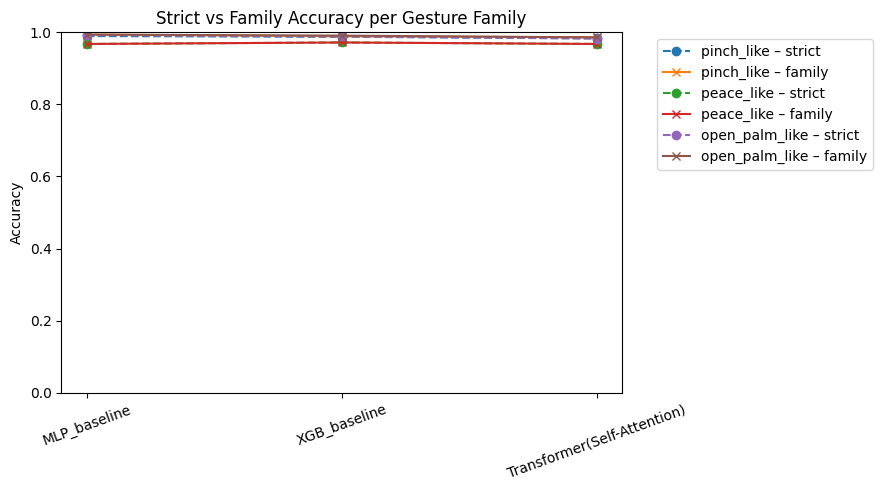

In [48]:
# Define gesture families (example – adjust to your label space)
# Keys are family names, values are lists of class indices that belong together.
SIMILAR_FAMILIES = {
    "pinch_like": [8, 9],          # e.g. pinch, love
    "peace_like": [2, 3],          # e.g. peace, victory
    "open_palm_like": [0, 1],      # e.g. open, stop
    # Add more as needed...
}

# Optional: if you have CLASS_NAMES, build readable names for families
CLASS_NAMES = globals().get("CLASS_NAMES", None)

def family_name(family_key):
    labels = SIMILAR_FAMILIES[family_key]
    if CLASS_NAMES is None:
        return f"{family_key} ({labels})"
    else:
        names = [CLASS_NAMES[l] for l in labels]
        return f"{family_key} ({', '.join(names)})"

family_rows = []

for model_name in MODEL_ORDER:
    y_pred = model_outputs[model_name]["y_pred"]
    
    for fam_key, fam_labels in SIMILAR_FAMILIES.items():
        fam_labels = np.array(fam_labels)
        
        # Restrict to samples where true label is in this family
        mask = np.isin(y_true, fam_labels)
        if not np.any(mask):
            continue  # no samples for this family
        
        y_true_fam = y_true[mask]
        y_pred_fam = y_pred[mask]
        
        # Strict accuracy: exact label match within family
        strict_acc = np.mean(y_true_fam == y_pred_fam)
        
        # Family accuracy: prediction is any label in the same family
        fam_acc = np.mean(np.isin(y_pred_fam, fam_labels))
        
        family_rows.append({
            "model": model_name,
            "family": fam_key,
            "family_readable": family_name(fam_key),
            "num_samples": len(y_true_fam),
            "strict_accuracy": strict_acc,
            "family_accuracy": fam_acc,
            "smartness_gain": fam_acc - strict_acc,  # how often it's "almost right"
        })

family_df = pd.DataFrame(family_rows)
display(family_df.sort_values(["family", "model"]))

# Plot: strict vs family accuracy per model, per family
plt.figure(figsize=(9, 5))
for fam_key in SIMILAR_FAMILIES.keys():
    sub = family_df[family_df["family"] == fam_key]
    if sub.empty:
        continue
    plt.plot(
        sub["model"],
        sub["strict_accuracy"],
        marker="o",
        linestyle="--",
        label=f"{fam_key} – strict"
    )
    plt.plot(
        sub["model"],
        sub["family_accuracy"],
        marker="x",
        linestyle="-",
        label=f"{fam_key} – family"
    )

plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Strict vs Family Accuracy per Gesture Family")
plt.xticks(rotation=20)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.tight_layout()
plt.show()


### 9.3.3 Pairwise Discrimination for Similar Gestures

For very similar gestures (e.g. pinch vs love), we build **binary subtasks**:

- Only keep samples where the true label is one of the two gestures.
- Evaluate how well each model solves “**A vs B**”.

We aggregate a score across all pairs we care about to get a **fine-grained discrimination score** for each model.


In [49]:
from sklearn.metrics import accuracy_score, f1_score

# Define specific pairs of similar classes to test as binary tasks
SIMILAR_PAIRS = [
    (8, 9),  # pinch vs love
    (2, 3),  # peace vs victory
    # add more pairs as needed
]

pair_rows = []

for model_name in MODEL_ORDER:
    y_pred = model_outputs[model_name]["y_pred"]
    
    for (a, b) in SIMILAR_PAIRS:
        # Filter to samples where true label is a or b
        mask = np.isin(y_true, [a, b])
        if not np.any(mask):
            continue
        
        y_true_pair = y_true[mask]
        y_pred_pair = y_pred[mask]
        
        # Map {a, b} → {0, 1}
        mapping = {a: 0, b: 1}
        y_true_bin = np.vectorize(mapping.get)(y_true_pair)
        
        # For the binary task, any prediction not in {a, b} is counted as wrong:
        # assign it to the opposite of the true label
        y_pred_bin = np.where(
            y_pred_pair == a, 0,
            np.where(y_pred_pair == b, 1, 1 - y_true_bin)
        )
        
        acc = accuracy_score(y_true_bin, y_pred_bin)
        macro_f1 = f1_score(y_true_bin, y_pred_bin, average="macro")
        
        # Nice label names if available
        if CLASS_NAMES is not None:
            a_name = CLASS_NAMES[a]
            b_name = CLASS_NAMES[b]
            pair_label = f"{a} ({a_name}) vs {b} ({b_name})"
        else:
            pair_label = f"{a} vs {b}"
        
        pair_rows.append({
            "model": model_name,
            "pair": pair_label,
            "num_samples": len(y_true_pair),
            "binary_accuracy": acc,
            "binary_macro_f1": macro_f1,
        })

pair_df = pd.DataFrame(pair_rows)
display(pair_df.sort_values(["pair", "model"]))

# Aggregate a "fine-grained discrimination" score per model
agg_pair = (
    pair_df
    .groupby("model")[["binary_accuracy", "binary_macro_f1"]]
    .mean()
    .reset_index()
)
agg_pair["num_pairs"] = pair_df.groupby("model").size().values

print("Average pairwise discrimination performance (across defined similar pairs):")
display(agg_pair)


,model,pair,num_samples,binary_accuracy,binary_macro_f1
1,MLP_baseline,2 vs 3,1457,0.967742,0.967740
5,Transformer(Self-Attention),2 vs 3,1457,0.967742,0.967740
3,XGB_baseline,2 vs 3,1457,0.971860,0.971858
0,MLP_baseline,8 vs 9,1448,0.989641,0.989641
4,Transformer(Self-Attention),8 vs 9,1448,0.983425,0.983425
2,XGB_baseline,8 vs 9,1448,0.987569,0.987569


Average pairwise discrimination performance (across defined similar pairs):


,model,binary_accuracy,binary_macro_f1,num_pairs
0,MLP_baseline,0.978691,0.978691,2
1,Transformer(Self-Attention),0.975584,0.975583,2
2,XGB_baseline,0.979715,0.979713,2


### 9.3.4 Probability Margin Analysis on Similar Gestures

Here we inspect **class probabilities** (not just argmax) for similar gestures.

For each test sample belonging to any gesture family:

- Let `p_true` be the probability for the true class.
- Let `p_best_competitor` be the highest probability among **other labels in the same family**.
- Define the **margin**: `margin = p_true − p_best_competitor`.

A “smarter” model will tend to have:

- **larger margins when correct** (confident separation),
- **small or negative margins when confused** (close decision between similar gestures).


,model,family,true_label,pred_label,margin,correct
0,MLP_baseline,pinch_like,9,9,0.981674,True
1,MLP_baseline,pinch_like,9,9,0.999965,True
2,MLP_baseline,pinch_like,9,9,0.999991,True
3,MLP_baseline,pinch_like,8,8,0.999350,True
4,MLP_baseline,pinch_like,9,9,0.999712,True


,model,family,correct,mean,std,count
0,MLP_baseline,open_palm_like,False,-0.002980,0.351409,11
1,MLP_baseline,open_palm_like,True,0.982483,0.053950,1416
2,MLP_baseline,peace_like,False,0.159880,0.141969,47
3,MLP_baseline,peace_like,True,0.976918,0.060112,1410
4,MLP_baseline,pinch_like,False,-0.080577,0.444592,15
5,MLP_baseline,pinch_like,True,0.978564,0.072158,1433
6,Transformer(Self-Attention),open_palm_like,False,-0.005108,0.323528,25
7,Transformer(Self-Attention),open_palm_like,True,0.988075,0.055507,1402
8,Transformer(Self-Attention),peace_like,False,0.290412,0.168865,47
9,Transformer(Self-Attention),peace_like,True,0.979137,0.065590,1410


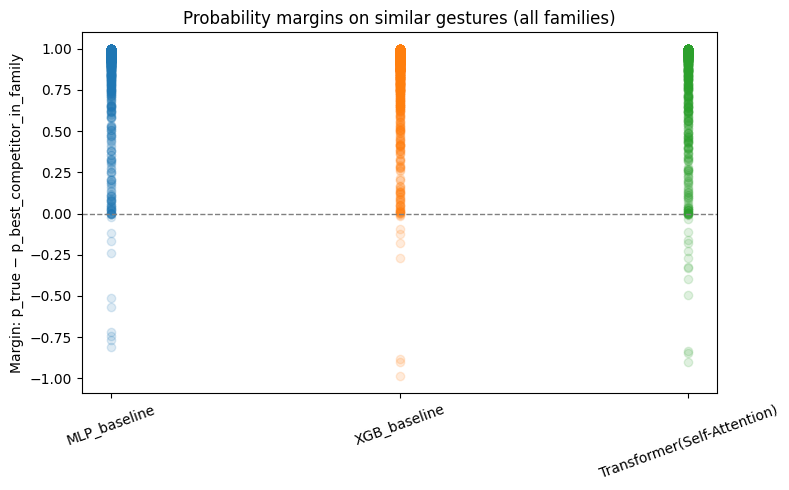

C:\Users\brian\AppData\Local\Temp\ipykernel_21920\2436062536.py:79: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=MODEL_ORDER, showfliers=False)


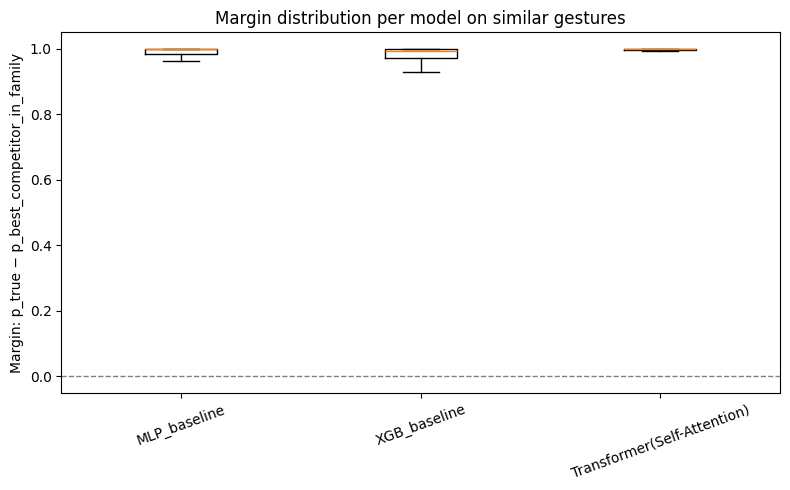

In [50]:
# Collect all labels that appear in gesture families
all_family_labels = sorted({lab for fam in SIMILAR_FAMILIES.values() for lab in fam})
all_family_labels = np.array(all_family_labels)

margin_rows = []

for model_name in MODEL_ORDER:
    proba = model_outputs[model_name]["proba"]  # shape: [N, NUM_CLASSES]
    preds = model_outputs[model_name]["y_pred"]
    
    for fam_key, fam_labels in SIMILAR_FAMILIES.items():
        fam_labels = np.array(fam_labels)
        
        # Samples where the true label belongs to this family
        mask = np.isin(y_true, fam_labels)
        if not np.any(mask):
            continue
        
        y_true_fam = y_true[mask]
        proba_fam = proba[mask]
        preds_fam = preds[mask]
        
        # Indices of the true classes & competitor probs inside the same family
        for yt, prob_vec, yp in zip(y_true_fam, proba_fam, preds_fam):
            p_true = prob_vec[yt]
            
            # Competitor probs: same family, excluding the true class
            competitor_labels = fam_labels[fam_labels != yt]
            if competitor_labels.size == 0:
                continue  # family of size 1
            
            p_competitors = prob_vec[competitor_labels]
            p_best_competitor = p_competitors.max()
            
            margin = p_true - p_best_competitor
            correct = (yt == yp)
            
            margin_rows.append({
                "model": model_name,
                "family": fam_key,
                "true_label": int(yt),
                "pred_label": int(yp),
                "margin": margin,
                "correct": correct,
            })

margin_df = pd.DataFrame(margin_rows)
display(margin_df.head())

# Summary: average margin per model/family, split by correct vs incorrect
summary_margin = (
    margin_df
    .groupby(["model", "family", "correct"])["margin"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
display(summary_margin)

# Plot: margin distributions per model (all families combined)
plt.figure(figsize=(8, 5))
for model_name in MODEL_ORDER:
    sub = margin_df[margin_df["model"] == model_name]
    if sub.empty:
        continue
    # Slightly jitter x-position per model
    x = np.full(len(sub), MODEL_ORDER.index(model_name))
    plt.scatter(x, sub["margin"], alpha=0.15, label=model_name if model_name == MODEL_ORDER[0] else None)

plt.axhline(0.0, color="gray", linestyle="--", linewidth=1)
plt.xticks(range(len(MODEL_ORDER)), MODEL_ORDER, rotation=20)
plt.ylabel("Margin: p_true − p_best_competitor_in_family")
plt.title("Probability margins on similar gestures (all families)")
plt.tight_layout()
plt.show()

# Optional: boxplot of margins per model (easier to read than scatter)
plt.figure(figsize=(8, 5))
box_data = [margin_df[margin_df["model"] == m]["margin"] for m in MODEL_ORDER]
plt.boxplot(box_data, labels=MODEL_ORDER, showfliers=False)
plt.axhline(0.0, color="gray", linestyle="--", linewidth=1)
plt.ylabel("Margin: p_true − p_best_competitor_in_family")
plt.title("Margin distribution per model on similar gestures")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


### 9.4 Top-k Accuracy

For some applications it is acceptable if the **correct class appears among the top-k predictions**, not necessarily as the top-1.  
We report **Top-k accuracy** for selected values of *k* (e.g. 1 and 3):

- **Top-1**: standard accuracy (already seen above).
- **Top-3**: correct label is among the 3 most probable classes.


,model,k,top_k_accuracy
0,MLP_baseline,1,0.983682
1,MLP_baseline,3,0.998047
2,XGB_baseline,1,0.984240
3,XGB_baseline,3,0.997629
4,Transformer(Self-Attention),1,0.975732
5,Transformer(Self-Attention),3,0.996932


<Figure size 800x400 with 0 Axes>

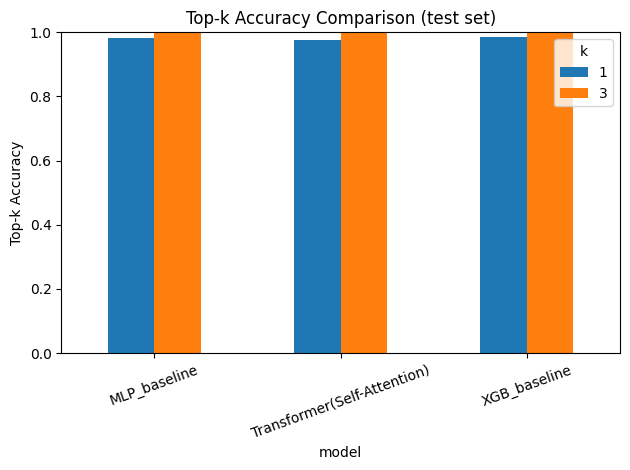

In [38]:
def top_k_accuracy(y_true, proba, k=3):
    """Compute Top-k accuracy given probabilities."""
    # Indices of top-k classes for each sample (descending prob)
    top_k = np.argsort(-proba, axis=1)[:, :k]
    correct = [
        1.0 if yt in top_k_row else 0.0
        for yt, top_k_row in zip(y_true, top_k)
    ]
    return np.mean(correct)

TOP_K_VALUES = [1, 3]

rows = []
for model_name in MODEL_ORDER:
    proba = model_outputs[model_name]["proba"]
    for k in TOP_K_VALUES:
        if k <= NUM_CLASSES:
            acc_k = top_k_accuracy(y_true, proba, k=k)
            rows.append({
                "model": model_name,
                "k": k,
                "top_k_accuracy": acc_k,
            })

topk_df = pd.DataFrame(rows)
display(topk_df)

plt.figure(figsize=(8, 4))
pivot_topk = topk_df.pivot(index="model", columns="k", values="top_k_accuracy")
pivot_topk.plot(kind="bar")
plt.ylim(0, 1.0)
plt.ylabel("Top-k Accuracy")
plt.title("Top-k Accuracy Comparison (test set)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


### 9.5 Robustness to Landmark Noise

To assess robustness, we add **Gaussian noise** to the landmark coordinates:

- Perturb all keypoint coordinates by `N(0, σ²)` with some standard deviation `σ`.
- Recompute test accuracy under noisy inputs.
- Compare how much performance degrades.

This simulates noisy landmark detection or tracking errors in upstream pipelines.


,model,noise_std,mean_noisy_accuracy,std_noisy_accuracy
0,MLP_baseline,0.00,0.983682,0.000000
1,MLP_baseline,0.04,0.966639,0.001880
2,MLP_baseline,0.08,0.889958,0.003224
3,MLP_baseline,0.12,0.778298,0.004081
4,MLP_baseline,0.16,0.665802,0.001191
5,MLP_baseline,0.20,0.561702,0.001944
12,Transformer(Self-Attention),0.00,0.975732,0.000000
13,Transformer(Self-Attention),0.04,0.897406,0.003521
14,Transformer(Self-Attention),0.08,0.644073,0.003339
15,Transformer(Self-Attention),0.12,0.434254,0.002704


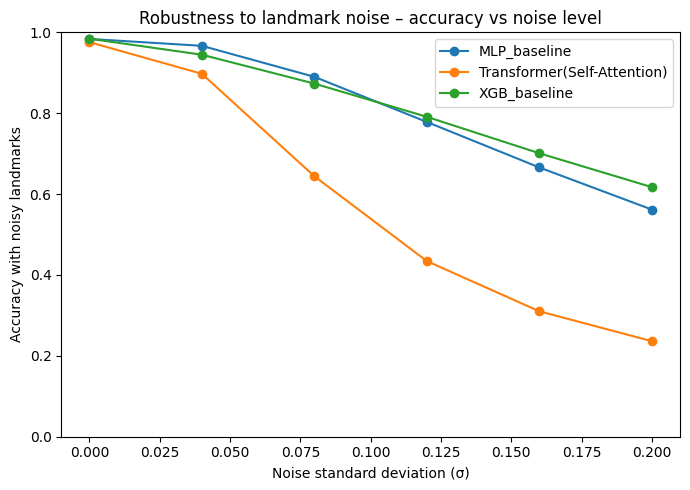

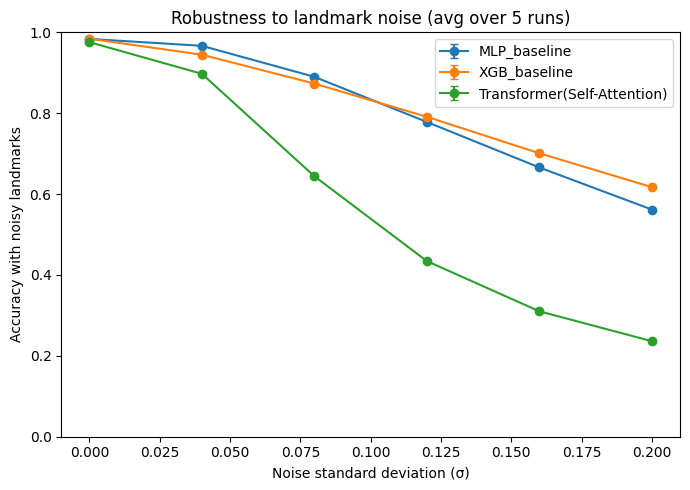

In [47]:
NOISE_STDS = np.linspace(0.0, 0.2, 6)   # e.g. [0.00, 0.04, 0.08, 0.12, 0.16, 0.20]
N_NOISE_RUNS = 5                        # runs per noise level for averaging

def add_landmark_noise(X, noise_std):
    """Add i.i.d. Gaussian noise to all landmark coordinates."""
    noise = np.random.normal(loc=0.0, scale=noise_std, size=X.shape)
    return X + noise

noise_rows = []

for model_name in MODEL_ORDER:
    fn = model_callables[model_name]
    
    for noise_std in NOISE_STDS:
        accs = []
        for _ in range(N_NOISE_RUNS):
            X_noisy = add_landmark_noise(X_test, noise_std)
            y_pred_noisy = fn(X_noisy)
            accs.append(accuracy_score(y_true, y_pred_noisy))
        
        noise_rows.append({
            "model": model_name,
            "noise_std": noise_std,
            "mean_noisy_accuracy": np.mean(accs),
            "std_noisy_accuracy": np.std(accs),
        })

noise_df = pd.DataFrame(noise_rows)
display(noise_df.sort_values(["model", "noise_std"]))

# Plot: accuracy vs noise for each model
plt.figure(figsize=(7, 5))
pivot = noise_df.pivot(index="noise_std", columns="model", values="mean_noisy_accuracy")

for model_name in pivot.columns:
    plt.plot(pivot.index, pivot[model_name], marker="o", label=model_name)

plt.ylim(0, 1.0)
plt.xlabel("Noise standard deviation (σ)")
plt.ylabel("Accuracy with noisy landmarks")
plt.title("Robustness to landmark noise – accuracy vs noise level")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: same plot with error bars (std over runs)
plt.figure(figsize=(7, 5))
for model_name in MODEL_ORDER:
    sub = noise_df[noise_df["model"] == model_name].sort_values("noise_std")
    plt.errorbar(
        sub["noise_std"],
        sub["mean_noisy_accuracy"],
        yerr=sub["std_noisy_accuracy"],
        marker="o",
        capsize=3,
        label=model_name,
    )

plt.ylim(0, 1.0)
plt.xlabel("Noise standard deviation (σ)")
plt.ylabel("Accuracy with noisy landmarks")
plt.title(f"Robustness to landmark noise (avg over {N_NOISE_RUNS} runs)")
plt.legend()
plt.tight_layout()
plt.show()


### 9.6 Inference Latency & Prediction Speed

We measure **inference latency** and **prediction throughput** on the test set:

- Run multiple inference passes on `X_test`.
- Report:
  - average **latency per sample** (ms),
  - average **throughput** (samples/second).

This captures how fast each model is at prediction time.


,model,latency_ms_per_sample,throughput_samples_per_s
0,MLP_baseline,0.034361,29102.450788
1,XGB_baseline,0.006172,162023.414078
2,Transformer(Self-Attention),0.145092,6892.185447


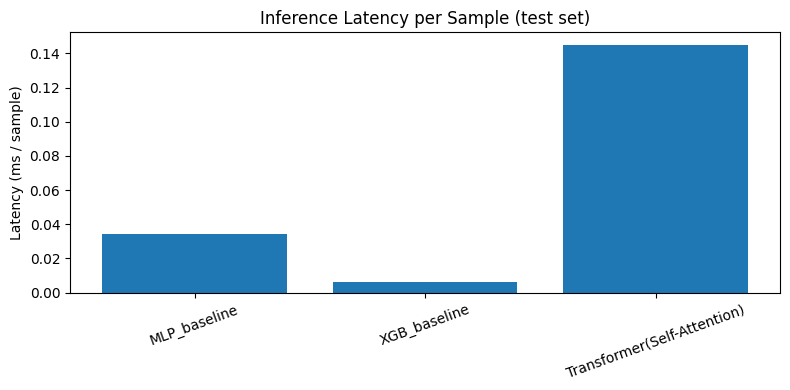

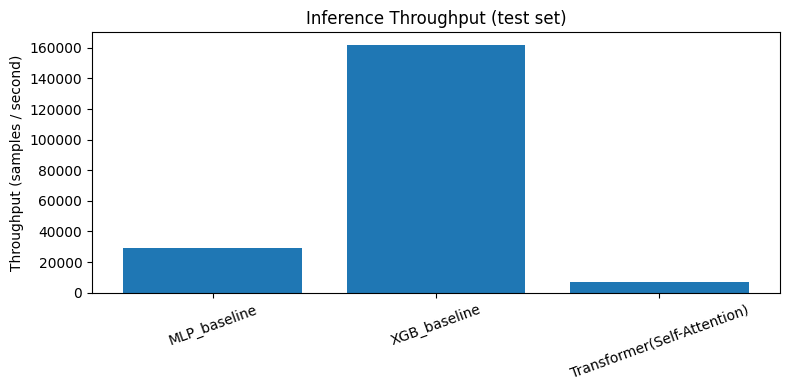

In [40]:
import time

N_LATENCY_RUNS = 30

latency_rows = []

for model_name in MODEL_ORDER:
    fn = model_callables[model_name]
    timings = []
    for _ in range(N_LATENCY_RUNS):
        start = time.perf_counter()
        _ = fn(X_test)
        end = time.perf_counter()
        timings.append(end - start)
    
    mean_time = np.mean(timings)
    latency_ms_per_sample = (mean_time / len(X_test)) * 1000.0
    throughput_samples_per_s = len(X_test) / mean_time
    
    latency_rows.append({
        "model": model_name,
        "latency_ms_per_sample": latency_ms_per_sample,
        "throughput_samples_per_s": throughput_samples_per_s,
    })

latency_df = pd.DataFrame(latency_rows)
display(latency_df)

plt.figure(figsize=(8, 4))
plt.bar(latency_df["model"], latency_df["latency_ms_per_sample"])
plt.ylabel("Latency (ms / sample)")
plt.title("Inference Latency per Sample (test set)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(latency_df["model"], latency_df["throughput_samples_per_s"])
plt.ylabel("Throughput (samples / second)")
plt.title("Inference Throughput (test set)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


### 9.7 Training Time

We compare **training wall-clock time** for each model.

> ⚠️ To populate these numbers, record training time in the training cells, e.g.:
>
> ```python
> import time
> start = time.perf_counter()
> hist_mlp = mlp_baseline.fit(...)
> mlp_train_time_s = time.perf_counter() - start
> ```
>
> Do similarly for `xgb_model` and `transformer`, storing:
> - `mlp_train_time_s`
> - `xgb_train_time_s`
> - `attn_train_time_s`


,model,train_time_s
0,MLP_baseline,NaN
1,XGB_baseline,NaN
2,Transformer(Self-Attention),NaN


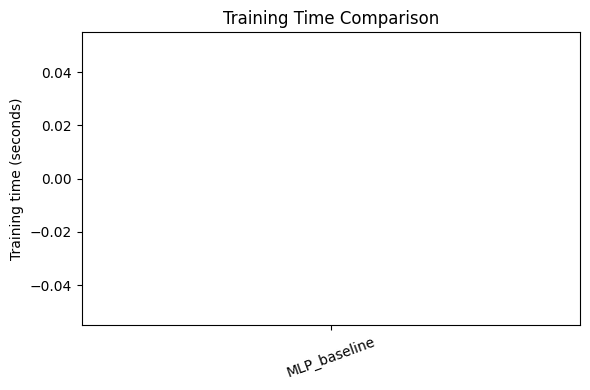

In [41]:
# Use pre-recorded training times if available; otherwise NaN
mlp_train_time_s = globals().get("mlp_train_time_s", np.nan)
xgb_train_time_s = globals().get("xgb_train_time_s", np.nan)
attn_train_time_s = globals().get("attn_train_time_s", np.nan)

train_rows = [
    {"model": "MLP_baseline", "train_time_s": mlp_train_time_s},
    {"model": "XGB_baseline", "train_time_s": xgb_train_time_s},
    {"model": "Transformer(Self-Attention)", "train_time_s": attn_train_time_s},
]

train_df = pd.DataFrame(train_rows)
display(train_df)

plt.figure(figsize=(6, 4))
plt.bar(train_df["model"], train_df["train_time_s"])
plt.ylabel("Training time (seconds)")
plt.title("Training Time Comparison")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


### 9.8 Model Size (Parameters / Approx. Memory Footprint)

We compare model **size / complexity**:

- For Keras models (MLP, Transformer):
  - **Number of trainable parameters**
  - Approximate **memory footprint of weights** (MiB)
- For XGBoost:
  - We approximate size via the raw booster serialization.


,model,num_params,approx_size_MiB
0,MLP_baseline,5162.0,0.019691
1,XGB_baseline,955369.5,3.644445
2,Transformer(Self-Attention),167242.0,0.637978


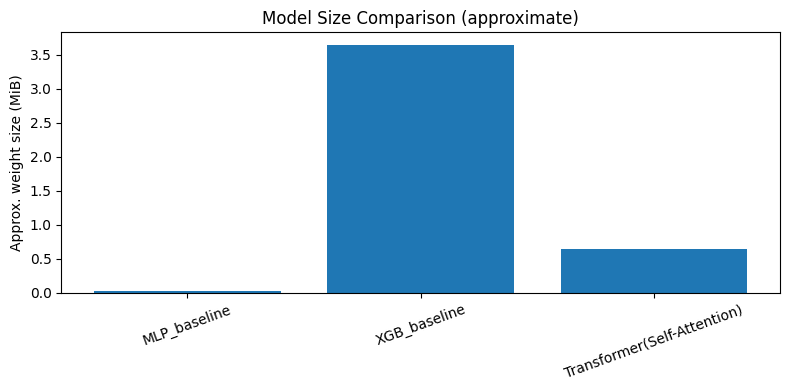

In [42]:
import math

def keras_model_size(model):
    """Return (num_params, bytes_of_weights)."""
    total_params = model.count_params()
    total_bytes = 0
    for w in model.get_weights():
        total_bytes += w.size * w.dtype.itemsize
    return total_params, total_bytes

# MLP & Transformer (Keras)
mlp_params, mlp_bytes = keras_model_size(mlp_baseline)
attn_params, attn_bytes = keras_model_size(transformer)

# XGBoost: approximate size via raw booster bytes
booster_raw = xgb_model.get_booster().save_raw()
xgb_bytes = len(booster_raw)
xgb_params_approx = xgb_bytes / 4.0  # rough "float32-equivalent" parameter count

size_rows = [
    {
        "model": "MLP_baseline",
        "num_params": mlp_params,
        "approx_size_MiB": mlp_bytes / (1024 ** 2),
    },
    {
        "model": "XGB_baseline",
        "num_params": xgb_params_approx,
        "approx_size_MiB": xgb_bytes / (1024 ** 2),
    },
    {
        "model": "Transformer(Self-Attention)",
        "num_params": attn_params,
        "approx_size_MiB": attn_bytes / (1024 ** 2),
    },
]

size_df = pd.DataFrame(size_rows)
display(size_df)

plt.figure(figsize=(8, 4))
plt.bar(size_df["model"], size_df["approx_size_MiB"])
plt.ylabel("Approx. weight size (MiB)")
plt.title("Model Size Comparison (approximate)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


### 9.9 Statistical Significance (McNemar’s Test)

Finally, we test whether differences in **error patterns** between pairs of models are
**statistically significant** using **McNemar’s test**:

- Build a 2×2 contingency table of disagreements on the test set:
  - *b*: model A correct, model B wrong  
  - *c*: model A wrong, model B correct
- Compute a chi-square statistic with continuity correction.
- Report the approximate **p-value** (lower → more significant difference).

We test all three pairwise comparisons:

- MLP vs XGBoost
- MLP vs Transformer
- XGBoost vs Transformer


In [43]:
import math

def mcnemar_test(y_true, y_pred1, y_pred2):
    """
    McNemar's test with continuity correction.
    Returns (chi2_statistic, p_value, b, c).
    """
    y_true = np.asarray(y_true)
    y_pred1 = np.asarray(y_pred1)
    y_pred2 = np.asarray(y_pred2)

    correct1 = (y_true == y_pred1)
    correct2 = (y_true == y_pred2)

    # b: model1 correct, model2 wrong
    # c: model1 wrong,  model2 correct
    b = int(np.sum((correct1 == 1) & (correct2 == 0)))
    c = int(np.sum((correct1 == 0) & (correct2 == 1)))

    n = b + c
    if n == 0:
        return 0.0, 1.0, b, c  # identical predictions

    # McNemar statistic with continuity correction
    chi2 = (abs(b - c) - 1) ** 2 / n

    # Chi-square(1) CDF uses the relation: CDF(x;1) = erf(sqrt(x/2))
    # p-value is survival function: 1 - CDF
    p_value = 1.0 - math.erf(math.sqrt(chi2 / 2.0))

    return chi2, p_value, b, c

pairs = [
    ("MLP_baseline", "XGB_baseline"),
    ("MLP_baseline", "Transformer(Self-Attention)"),
    ("XGB_baseline", "Transformer(Self-Attention)"),
]

mcnemar_rows = []

for m1, m2 in pairs:
    y1 = model_outputs[m1]["y_pred"]
    y2 = model_outputs[m2]["y_pred"]
    chi2, p, b, c = mcnemar_test(y_true, y1, y2)
    mcnemar_rows.append({
        "model_A": m1,
        "model_B": m2,
        "b (A correct, B wrong)": b,
        "c (A wrong, B correct)": c,
        "chi2": chi2,
        "p_value": p,
    })

mcnemar_df = pd.DataFrame(mcnemar_rows)
display(mcnemar_df)


,model_A,model_B,"b (A correct, B wrong)","c (A wrong, B correct)",chi2,p_value
0,MLP_baseline,XGB_baseline,53,57,0.081818,0.774848
1,MLP_baseline,Transformer(Self-Attention),133,76,15.004785,0.000107
2,XGB_baseline,Transformer(Self-Attention),132,71,17.733990,0.000025


## 10. Discussion: Use Cases, Limitations, and Trade-offs

**When to prefer the Transformer over MLP/XGBoost**
- You expect **inter-joint relations** to matter (e.g., angles/distances capturing fine-grained shapes).
- You want a **compact, fully differentiable** model deployable on-device (e.g., TFLite) with hardware-accelerated ops.

**When baselines may suffice**
- **MLP**: very fast & tiny; performs well when the signal is strong without complex relationships.
- **XGBoost**: robust with little tuning; can perform strongly with tabular data; easy to interpret feature importance.

**Costs and constraints**
- Transformers add **attention layers** with O(N²) interactions over 21 tokens — still cheap for 21, but heavier than an MLP.
- Slightly more sensitive to hyperparameters; use **early stopping** & **dropout** to regularise.

**Practicality**
- For real-time webcam pipelines, a small Transformer (e.g., `d_model=64`, `heads=4`, `layers=2`) is typically **<1-2 ms** per sample on modern GPUs and tens of ms on CPU depending on hardware. Batch-1 inference is standard for streaming.


## 11. Deployment Considerations (TFLite)

Exporting to **TensorFlow Lite** mirrors the prior MLP notebook. Quantisation can reduce size/latency with minimal accuracy loss.


In [27]:
# Convert the Transformer to TFLite (quantized) - optional
save_dir = "../models/keypoint"
os.makedirs(save_dir, exist_ok=True)
keras_path  = os.path.join(save_dir, f"keypoint_classifier_transformer_self_attention_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.keras")
tflite_path = os.path.join(save_dir, f"keypoint_classifier_transformer_self_attention_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.tflite")

# Save the Keras model without optimizer state (slightly smaller)
transformer.save(keras_path, include_optimizer=False)

converter = tf.lite.TFLiteConverter.from_keras_model(transformer)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # enables post-training quantization
tflite_quant_model = converter.convert()

with open(tflite_path, "wb") as f:
    f.write(tflite_quant_model)

print("Saved Keras model to:", keras_path)
print("Saved TFLite model to:", tflite_path)


INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmpd349jgay\assets


INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmpd349jgay\assets


Saved artifact at 'C:\Users\brian\AppData\Local\Temp\tmpd349jgay'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='keras_tensor_130')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1587275564816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587275567696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587275573840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587275565200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587275564240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587275563280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587275573072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587275573456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587275571920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587275573264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  158727557

### TFLite Inference Test

We verify the TFLite model by running inference on a random test sample and visualizing the result.


Test Sample Index: 860
True Label: 4
Predicted Label (TFLite): 4


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


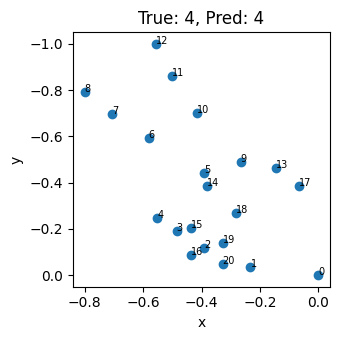

In [28]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def run_tflite_inference(interpreter, input_data):
    input_shape = input_details[0]['shape']
    # Ensure input data is float32 and matches shape
    input_data = np.array(input_data, dtype=np.float32).reshape(input_shape)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return np.argmax(output_data)

def plot_hand_keypoints(sample, num_landmarks=21, title="Hand keypoints"):
    pts = sample.reshape(num_landmarks, 2)
    xs, ys = pts[:,0], pts[:,1]
    plt.figure(figsize=(3.5, 3.5))
    plt.scatter(xs, ys)
    for i,(x,y) in enumerate(pts):
        plt.text(x, y, str(i), fontsize=7)
    plt.gca().invert_yaxis()
    plt.title(title); plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout(); plt.show()

# Select a random sample from test set
idx = np.random.randint(0, len(X_test))
sample = X_test[idx]
true_label = y_test[idx]

# Run inference
pred_label = run_tflite_inference(interpreter, sample)

# Visualize
print(f"Test Sample Index: {idx}")
print(f"True Label: {true_label}")
print(f"Predicted Label (TFLite): {pred_label}")
plot_hand_keypoints(sample, title=f"True: {true_label}, Pred: {pred_label}")
